### Aim:

In this notebook, two different tree-based ensemble models - Random Forest and Gradient boosting - will be used to evaluate what additive effect (if any) ToxCast targets provide *for predicting mostDILI drugs* - when compared to existing predictors currently used in the field (eg: Chen M et al., 2016 Hepatol, Shah F et al., 2015 Toxicol Sci).

Relative performance of "optimized" random forest and gradient boosting models will be compared to choose "best" ensemble model for mostDILI predictions.

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
plt.style.use('seaborn') 

%matplotlib inline

import pandas_profiling

In [86]:
#magic command to print all output instead of only last line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Read-in datasets, prepare data for ML

All datasets have been previously treated for missing values and dummy coding of categorical variables(reactive_metabolites, classificn, and ~216 toxcast targets).
Output/target/Y variable for modeling purposes is "classificn" (1="mostDILI", 0 = "other" which includes lessDILI/ambiDILI/noDILI). <br>

In this notebook, same datasets previosuly used for logistic regression modeling will be imported. No EDA will be performed as the datasetts are identical to those previously used and EDA has already been done within the notebook using logistic regression as initial model.

Data once imported will be transformed into feature dataset ("X") and label dataset ("Y") and further split using stratified sampling with call to test train split function. For allowing to compare results from logistic regression, same random state will be used as before.

In [87]:
mc = pd.read_csv("mc_scaled_labeled.csv")
tc = pd.read_csv("tc_pca_labeled.csv")
mc_tc=pd.read_csv("mctc_pca_labeled.csv")

In [88]:
#Create "x" consisting of all independent variables from each of the dataframes (mc, tc, mc_tc) to be used for modeling

mc_num=mc.select_dtypes(include=[np.number])
x_mc=mc_num.drop(["classificn"], axis=1)

tc_num=tc.select_dtypes(include=[np.number])
x_tc=tc_num.drop(["classificn"], axis=1)

mc_tc_num=mc_tc.select_dtypes(include=[np.number])
x_mc_tc=mc_tc_num.drop(["classificn"], axis=1)

In [89]:
#create "y" consisting of outcome/target variable from each of the dataframes (mc, tc, mc_tc) to be used for modeling

y_mc=mc_num["classificn"] 
y_tc=tc_num["classificn"]
y_mc_tc=mc_tc_num["classificn"]

#check to make sure all datasets are equivalent for classification column
y_mc.equals(y_tc)
y_mc.equals(y_mc_tc)
y_tc.equals(y_mc_tc)

#breakdown of mostDILI drugs vs other drugs
y_mc.value_counts()#60 drugs are labeled as "mostDILI" and 115 drugs as "other"

True

True

True

0    115
1     60
Name: classificn, dtype: int64

In [90]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics

## test train stratified split at 40:60 ratio (maintains ratio of mostDILI drugs:other drugs)
# allows for testing on 24 "mostDILI" and training on 36 "mostDILI" drugs
train_mcx, test_mcx, train_mcy, test_mcy = train_test_split(x_mc,y_mc, stratify=y_mc, test_size=0.4, random_state=45)

train_tcx, test_tcx, train_tcy, test_tcy = train_test_split(x_tc,y_tc, stratify=y_tc, test_size=0.4, random_state=45)

train_mctcx, test_mctcx, train_mctcy, test_mctcy = train_test_split(x_mc_tc,y_mc_tc, stratify=y_mc_tc, test_size=0.4, random_state=45)

#confirm that test datasets are same across all splits
test_mctcy.equals(test_tcy)
test_mcy.equals(test_tcy)

True

True

### Random Forest modeling 

In [91]:
# Initial model - Instantiate & Fit
from sklearn.ensemble import RandomForestClassifier

rf_mc = RandomForestClassifier(n_estimators = 500, random_state = 1, class_weight='balanced', oob_score = True)
rf_tc = RandomForestClassifier(n_estimators = 500, random_state = 1, class_weight='balanced', oob_score=True)
rf_mctc = RandomForestClassifier(n_estimators = 500, random_state = 1, class_weight='balanced', oob_score=True)

rf_mc.fit(train_mcx, train_mcy)
rf_tc.fit(train_tcx, train_tcy)
rf_mctc.fit(train_mctcx, train_mctcy)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

#### Tune random forest model for each of the datasets

In [92]:
from sklearn.grid_search import GridSearchCV

grid_mc = GridSearchCV(estimator = rf_mc, cv=3, scoring='roc_auc',n_jobs=-1,
                       param_grid={'n_estimators':[int(x) for x in np.linspace(start = 200, stop = 900, num = 10)],
                                    'max_features' : ['auto', 'sqrt', 'log2'],
                                    'criterion': ['gini', 'entropy']})

grid_tc = GridSearchCV(estimator = rf_tc, cv=3, scoring='roc_auc',n_jobs=-1,
                    param_grid={'n_estimators':[int(x) for x in np.linspace(start = 200, stop = 900, num = 10)],
                                    'max_features' : ['auto', 'sqrt', 'log2'],
                                    'criterion': ['gini', 'entropy']})

grid_mctc= GridSearchCV(estimator = rf_mctc, cv=3, scoring='roc_auc',n_jobs=-1,
                    param_grid={'n_estimators':[int(x) for x in np.linspace(start = 200, stop = 900, num = 10)],
                                    'max_features' : ['auto', 'sqrt', 'log2'],
                                    'criterion': ['gini', 'entropy']})

In [93]:
#"fit" grid search models (commented out to avoid re-implementation)
#grid_mc.fit(train_mcx,train_mcy)
#grid_tc.fit(train_tcx, train_tcy)
#grid_mctc.fit(train_mctcx, train_mctcy)

In [94]:
print("RF best params follow below - mc data ")
#grid_mc.best_params_
print("")

print("RF best params follow below - tc data ")
#grid_tc.best_params_
print("")

print("RF best params follow below - mctc data ")
#grid_mctc.best_params_
print("")

RF best params follow below - mc data 

RF best params follow below - tc data 

RF best params follow below - mctc data 



#### Optimized random forest model for each dataset

In [95]:
#Instantiate random forest models with optimal parameters
rf_mc = RandomForestClassifier(criterion='entropy', n_estimators = 433, max_features='auto', random_state = 1, n_jobs=-1, class_weight='balanced', oob_score=True)
rf_tc = RandomForestClassifier(criterion='entropy', n_estimators = 200, max_features='log2', random_state = 1, n_jobs=-1, class_weight='balanced', oob_score=True)
rf_mctc = RandomForestClassifier(criterion='entropy', n_estimators = 744, max_features='auto', random_state = 1, n_jobs=-1, class_weight='balanced', oob_score=True)

In [96]:
#Fit data to optimal model parameters 
rf_mc.fit(train_mcx, train_mcy)
rf_tc.fit(train_tcx, train_tcy)
rf_mctc.fit(train_mctcx, train_mctcy)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=433, n_jobs=-1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=744, n_jobs=-1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

In [97]:
#Predict classification labels based on optimal model parameters

### Using random forest model fitted using variables from Chen et al (mc), predict test values and probabilities  mc
rf_pred_mcy=rf_mc.predict(test_mcx) 
rf_probs_mcy=rf_mc.predict_proba(test_mcx) 

### Using random forest model fitted using variables from ToxCast (tc), predict test values and probabilities  mc
rf_pred_tcy=rf_tc.predict(test_tcx) 
rf_probs_tcy=rf_tc.predict_proba(test_tcx) 

### Using random forest model fitted using variables from Chen et al & ToxCast (mctc), predict test values and probabilities  mc
rf_pred_mctcy=rf_mctc.predict(test_mctcx) 
rf_probs_mctcy=rf_mctc.predict_proba(test_mctcx)    

#### Optimal random forest metrics for each dataset

In [98]:
from sklearn.model_selection import cross_val_score

rf_accuracy_scores_mc = cross_val_score(rf_mc, x_mc, y_mc, cv=3, scoring='accuracy')
print("Accuracy: 3-fold cross validation scores on random forest model using mc (Chen M et al., 2016 Hepatol) variables")
print(rf_accuracy_scores_mc)
print("Accuracy mean: " +str(rf_accuracy_scores_mc.mean()), "Accuracy standard deviation: " + str(rf_accuracy_scores_mc.std()))
print("")

rf_accuracy_scores_tc = cross_val_score(rf_tc, x_tc, y_tc, cv=3, scoring='accuracy')
print("Accuracy: 3-fold cross validation scores on random forest model using tc (ToxCast targets/pathways) variables")
print(rf_accuracy_scores_tc)
print("Accuracy mean: " +str(rf_accuracy_scores_tc.mean()), "Accuracy standard deviation: " + str(rf_accuracy_scores_tc.std()))
print("")

rf_accuracy_scores_mctc = cross_val_score(rf_mctc, x_mc_tc, y_mc_tc, cv=3, scoring='accuracy')
print("Accuracy: 3-fold cross validation scores on random forest model using combined mc and tc (Chen M et al, 2016 Hepatol and ToxCast) variables")
print(rf_accuracy_scores_mctc)
print("Accuracy mean: " +str(rf_accuracy_scores_mctc.mean()), "Accuracy standard deviation: " + str(rf_accuracy_scores_mctc.std()))

Accuracy: 3-fold cross validation scores on random forest model using mc (Chen M et al., 2016 Hepatol) variables
[0.77966102 0.70689655 0.70689655]
Accuracy mean: 0.7311513734658095 Accuracy standard deviation: 0.03430149786001373

Accuracy: 3-fold cross validation scores on random forest model using tc (ToxCast targets/pathways) variables
[0.55932203 0.5        0.62068966]
Accuracy mean: 0.5600038963569062 Accuracy standard deviation: 0.04927370440521242

Accuracy: 3-fold cross validation scores on random forest model using combined mc and tc (Chen M et al, 2016 Hepatol and ToxCast) variables
[0.66101695 0.55172414 0.60344828]
Accuracy mean: 0.6053964543152153 Accuracy standard deviation: 0.0446398640651979


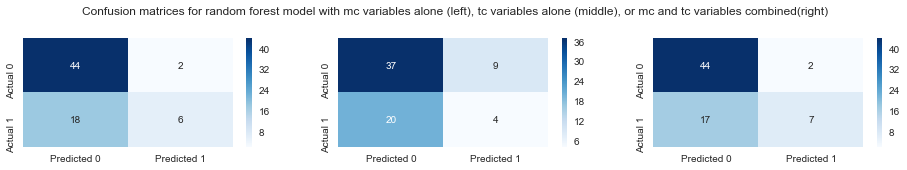

In [99]:
### Confusion Matrix
rf_cfm_mc=metrics.confusion_matrix(test_mcy, rf_pred_mcy)
rf_cfm_tc=metrics.confusion_matrix(test_tcy, rf_pred_tcy)
rf_cfm_mctc=metrics.confusion_matrix(test_mctcy, rf_pred_mctcy)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,2))

lbl1=["Predicted 0", "Predicted 1"]
lbl2=["Actual 0", "Actual 1"]

sns.heatmap(rf_cfm_mc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax1)
sns.heatmap(rf_cfm_tc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax2)
sns.heatmap(rf_cfm_mctc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax3)


fig.suptitle("Confusion matrices for random forest model with mc variables alone (left), tc variables alone (middle), or mc and tc variables combined(right)", y=1.1);

In [100]:
### Precision, Recall
rf_cr_mc=metrics.classification_report(test_mcy, rf_pred_mcy)
rf_cr_tc=metrics.classification_report(test_tcy, rf_pred_tcy)
rf_cr_mctc=metrics.classification_report(test_mctcy, rf_pred_mctcy)
print("precision_recall for model with mc variables alone")
print(rf_cr_mc)
print("precision_recall for model with tc variables alone")
print(rf_cr_tc)
print("precision_recall for model with mc&tc variables combined")
print(rf_cr_mctc)

precision_recall for model with mc variables alone
             precision    recall  f1-score   support

          0       0.71      0.96      0.81        46
          1       0.75      0.25      0.38        24

avg / total       0.72      0.71      0.66        70

precision_recall for model with tc variables alone
             precision    recall  f1-score   support

          0       0.65      0.80      0.72        46
          1       0.31      0.17      0.22        24

avg / total       0.53      0.59      0.55        70

precision_recall for model with mc&tc variables combined
             precision    recall  f1-score   support

          0       0.72      0.96      0.82        46
          1       0.78      0.29      0.42        24

avg / total       0.74      0.73      0.69        70



**Conclusion:** Random forest performs poorly relative to logistic regression for prediction of "mostDILI" label. <br>

Addition of toxcast variables has a very modest effect on model performance. Given the poor performance for Random foret relative to logistic regression - regardless of variables used - this algorithm will not be analyzed further for the problem at hand.

### Gradient Boosting Model

In [101]:
#Instantiate and Fit
from sklearn.ensemble import GradientBoostingClassifier

gb_mc=GradientBoostingClassifier(n_estimators=80,random_state=400)
gb_tc=GradientBoostingClassifier(n_estimators=80,random_state=400)
gb_mctc=GradientBoostingClassifier(n_estimators=80,random_state=400)

gb_mc.fit(train_mcx, train_mcy)
gb_tc.fit(train_tcx, train_tcy)
gb_mctc.fit(train_mctcx, train_mctcy)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=400, subsample=1.0, verbose=0,
              warm_start=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=400, subsample=1.0, verbose=0,
              warm_start=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=400, subsample=1.0, verbose=0,
              warm_start=False)

#### Tune gradient boosted model for each of the datasets

In [102]:
from sklearn.grid_search import GridSearchCV
# Grid search for n_estimators(trees) with 3-fold cross validation 
grid_mc = GridSearchCV(estimator = gb_mc, cv=3, scoring='roc_auc',n_jobs=-1,
                        param_grid={'n_estimators':[40, 60,80,100,120,140, 160],
                                    'max_depth':[2, 3, 4, 5,6],
                                   'learning_rate':[0.05, 0.02, 0.01, 0.005, 0.1, 0.2]})

grid_tc = GridSearchCV(estimator = gb_tc, cv=3, scoring='roc_auc',n_jobs=-1,
                       param_grid={'n_estimators':[40, 60,80,100,120,140, 160],
                                    'max_depth':[2, 3, 4, 5,6],
                                   'learning_rate':[0.05, 0.02, 0.01, 0.005, 0.1, 0.2]})

grid_mctc = GridSearchCV(estimator = gb_mctc, cv=3, scoring='roc_auc',n_jobs=-1,
                        param_grid={'n_estimators':[40, 60,80,100,120,140, 160],
                                    'max_depth':[2, 3, 4, 5,6],
                                   'learning_rate':[0.05, 0.02, 0.01, 0.005, 0.1, 0.2]})

In [103]:
#"fit" grid search models (commented out to avoid re-implementation)
#grid_mc.fit(train_mcx,train_mcy)
#grid_tc.fit(train_tcx, train_tcy)
#grid_mctc.fit(train_mctcx, train_mctcy)

In [104]:
print("gb best params follow below - mc data ")
#grid_mc.best_params_
print("")

print("gb best params follow below - tc data ")
#grid_tc.best_params_
print("")

print("gb best params follow below - mctc data ")
#grid_mctc.best_params_
print("")

gb best params follow below - mc data 

gb best params follow below - tc data 

gb best params follow below - mctc data 



#### Optimized gradient boosted tree model for each dataset

In [105]:
#Instantiate random forest models with optimal parameters
gb_mc = GradientBoostingClassifier(n_estimators = 60, max_depth=2, learning_rate = .01, random_state = 1)
gb_tc = GradientBoostingClassifier(n_estimators = 60, max_depth=5, learning_rate=.01, random_state = 1)
gb_mctc = GradientBoostingClassifier(n_estimators = 100, max_depth=2,learning_rate=.005,  random_state = 1)

In [106]:
#Fit data to optimal model parameters
gb_mc.fit(train_mcx, train_mcy)
gb_tc.fit(train_tcx, train_tcy)
gb_mctc.fit(train_mctcx, train_mctcy)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False)

In [107]:
#Predict classification labels based on optimal model parameters

### Using random forest model fitted using variables from Chen et al (mc), predict test values and probabilities  mc
gb_pred_mcy=gb_mc.predict(test_mcx) 
gb_probs_mcy=gb_mc.predict_proba(test_mcx) 

### Using random forest model fitted using variables from ToxCast (tc), predict test values and probabilities  mc
gb_pred_tcy=gb_tc.predict(test_tcx) 
gb_probs_tcy=gb_tc.predict_proba(test_tcx) 

### Using random forest model fitted using variables from Chen et al & ToxCast (mctc), predict test values and probabilities  mc
gb_pred_mctcy=gb_mctc.predict(test_mctcx) 
gb_probs_mctcy=gb_mctc.predict_proba(test_mctcx)    

#### Optimal Gradient Boosted model metrics for each dataset

In [108]:
from sklearn.model_selection import cross_val_score

gb_accuracy_scores_mc = cross_val_score(gb_mc, x_mc, y_mc, cv=3, scoring='accuracy')
print("Accuracy: 3-fold cross validation scores on gradient boosted model using mc (Chen M et al., 2016 Hepatol) variables")
print(gb_accuracy_scores_mc)
print("Accuracy mean: " +str(gb_accuracy_scores_mc.mean()), "Accuracy standard deviation: " + str(gb_accuracy_scores_mc.std()))
print("")

gb_accuracy_scores_tc = cross_val_score(gb_tc, x_tc, y_tc, cv=3, scoring='accuracy')
print("Accuracy: 3-fold cross validation scores on gradient boosted model using tc (ToxCast targets/pathways) variables")
print(gb_accuracy_scores_tc)
print("Accuracy mean: " +str(gb_accuracy_scores_tc.mean()), "Accuracy standard deviation: " + str(gb_accuracy_scores_tc.std()))
print("")

gb_accuracy_scores_mctc = cross_val_score(gb_mctc, x_mc_tc, y_mc_tc, cv=3, scoring='accuracy')
print("Accuracy: 3-fold cross validation scores on gradient boosted model using combined mc and tc (Chen M et al, 2016 Hepatol and ToxCast) variables")
print(gb_accuracy_scores_mctc)
print("Accuracy mean: " +str(gb_accuracy_scores_mctc.mean()), "Accuracy standard deviation: " + str(gb_accuracy_scores_mctc.std()))

Accuracy: 3-fold cross validation scores on gradient boosted model using mc (Chen M et al., 2016 Hepatol) variables
[0.71186441 0.65517241 0.67241379]
Accuracy mean: 0.6798168712254044 Accuracy standard deviation: 0.023729021492071838

Accuracy: 3-fold cross validation scores on gradient boosted model using tc (ToxCast targets/pathways) variables
[0.66101695 0.53448276 0.5862069 ]
Accuracy mean: 0.5939022014416521 Accuracy standard deviation: 0.05194316529566726

Accuracy: 3-fold cross validation scores on gradient boosted model using combined mc and tc (Chen M et al, 2016 Hepatol and ToxCast) variables
[0.6440678  0.62068966 0.5862069 ]
Accuracy mean: 0.6169881161114358 Accuracy standard deviation: 0.02376618020715305


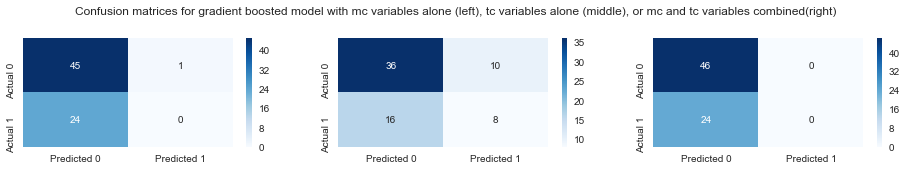

In [109]:
### Confusion Matrix
gb_cfm_mc=metrics.confusion_matrix(test_mcy, gb_pred_mcy)
gb_cfm_tc=metrics.confusion_matrix(test_tcy, gb_pred_tcy)
gb_cfm_mctc=metrics.confusion_matrix(test_mctcy, gb_pred_mctcy)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,2))

lbl1=["Predicted 0", "Predicted 1"]
lbl2=["Actual 0", "Actual 1"]

sns.heatmap(gb_cfm_mc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax1)
sns.heatmap(gb_cfm_tc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax2)
sns.heatmap(gb_cfm_mctc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax3)


fig.suptitle("Confusion matrices for gradient boosted model with mc variables alone (left), tc variables alone (middle), or mc and tc variables combined(right)", y=1.1);

In [110]:
### Precision, Recall
gb_cr_mc=metrics.classification_report(test_mcy, gb_pred_mcy)
gb_cr_tc=metrics.classification_report(test_tcy, gb_pred_tcy)
gb_cr_mctc=metrics.classification_report(test_mctcy, gb_pred_mctcy)
print("precision_recall for model with mc variables alone")
print(gb_cr_mc)
print("precision_recall for model with tc variables alone")
print(gb_cr_tc)
print("precision_recall for model with mc&tc variables combined")
print(gb_cr_mctc)

precision_recall for model with mc variables alone
             precision    recall  f1-score   support

          0       0.65      0.98      0.78        46
          1       0.00      0.00      0.00        24

avg / total       0.43      0.64      0.51        70

precision_recall for model with tc variables alone
             precision    recall  f1-score   support

          0       0.69      0.78      0.73        46
          1       0.44      0.33      0.38        24

avg / total       0.61      0.63      0.61        70

precision_recall for model with mc&tc variables combined
             precision    recall  f1-score   support

          0       0.66      1.00      0.79        46
          1       0.00      0.00      0.00        24

avg / total       0.43      0.66      0.52        70



C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [111]:
#calculate values to populate ROC curve
from sklearn.metrics import roc_curve

gb_fpr_mc,gb_tpr_mc, gb_thresholds_mc=roc_curve(test_mcy, gb_probs_mcy[:, 1])
gb_roc_auc_mc=metrics.auc(gb_fpr_mc, gb_tpr_mc)

gb_fpr_tc,gb_tpr_tc, gb_thresholds_tc=roc_curve(test_tcy, gb_probs_tcy[:, 1])
gb_roc_auc_tc=metrics.auc(gb_fpr_tc, gb_tpr_tc)

gb_fpr_mctc,gb_tpr_mctc, gb_thresholds_mctc=roc_curve(test_mctcy, gb_probs_mctcy[:, 1])
gb_roc_auc_mctc=metrics.auc(gb_fpr_mctc, gb_tpr_mctc)

#Calculate values to populate precision-recall curve
from sklearn.metrics import precision_recall_curve

gb_precision_mc, gb_recall_mc, gb_thresholds_mc = precision_recall_curve(test_mcy, gb_probs_mcy[:, 1]) #retrieve probability of being 1(in second column of probs_y)
gb_pr_auc_mc = metrics.auc(gb_recall_mc, gb_precision_mc)

gb_precision_tc, gb_recall_tc, gb_thresholds_tc = precision_recall_curve(test_tcy, gb_probs_tcy[:, 1]) #retrieve probability of being 1(in second column of probs_y)
gb_pr_auc_tc = metrics.auc(gb_recall_tc, gb_precision_tc)

gb_precision_mctc, gb_recall_mctc, gb_thresholds_mctc = precision_recall_curve(test_mctcy, gb_probs_mctcy[:, 1]) #retrieve probability of being 1(in second column of probs_y)
gb_pr_auc_mctc = metrics.auc(gb_recall_mctc, gb_precision_mctc)

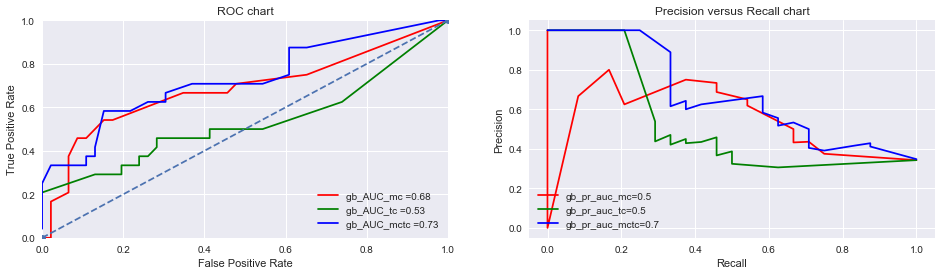

In [112]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(16)

axes = fig.add_subplot(121)

plt.title("ROC chart")
plt.plot(gb_fpr_mc, gb_tpr_mc, 'r', label='gb_AUC_mc =%0.2f'% gb_roc_auc_mc)
plt.plot(gb_fpr_tc, gb_tpr_tc, 'g', label='gb_AUC_tc =%0.2f'% gb_roc_auc_tc)
plt.plot(gb_fpr_mctc, gb_tpr_mctc, 'b', label='gb_AUC_mctc =%0.2f'% gb_roc_auc_mctc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'o--')
plt.axis([0,1, 0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")


axes = fig.add_subplot(122)
plt.title("Precision versus Recall chart")
plt.plot(gb_recall_mc, gb_precision_mc, "r", label = 'gb_pr_auc_mc=%.1f' % (gb_pr_auc_mc))
plt.plot(gb_recall_tc, gb_precision_tc, "g", label = 'gb_pr_auc_tc=%.1f' % (gb_pr_auc_tc))
plt.plot(gb_recall_mctc, gb_precision_mctc, "b", label = 'gb_pr_auc_mctc=%.1f' % (gb_pr_auc_mctc))
plt.legend(loc='lower left')
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show();

**Conclusion:** No benefit for using ensemble models with default variables currently in Chen M et al., 2016. Addition of ToxCast variables did not add any benefit to either model - and their performance is worse- than in a simple logistic regression.

No need to consider ensemble models further.